# Function Approximation
Generalizing the whole state space of a problem from a smaller subset of states. This is done to reduce computational complexity in large problems. Linear independence of variables is sacrificed for parameterization.

In [121]:
import torch
import gym
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import SGD, Adam
from math import pi

In [35]:
env = gym.make("MountainCar-v0")
num_actions = env.action_space.n
print(num_actions)
env.reset()

3


array([-0.57860685,  0.        ])

## Gradient Descent approximation
Features are used to estimate Q values. Each feature represents a variable state or combination of states. These features form a linear equation that can be approximated (deep learning style). 

Standard gradient descent algorithm, update value function with a factor of the gradient.

In [122]:
class QEstimator():
    def __init__(self, n_f, n_s, n_a, lr=0.05) -> None:
        # Different parameters of models used for different actions
        self.w, self.b = self.get_gaussian_wb(n_f, n_s)
        self.num_features = n_f
        self.models = []
        self.optims = []
        self.criterion = nn.MSELoss()
        for i in range(n_a):
            model = nn.Linear(self.num_features, 1)
            optim = SGD(model.parameters(), lr)
            self.optims.append(optim)
            self.models.append(model)

    def get_gaussian_wb(self, num_features, num_states, sigma=0.2):
        # Gaussian distribution of weights and biases
        torch.manual_seed(0)
        w = torch.randn((num_states, num_features)) * 1.0 / sigma
        b = torch.randn(num_features) * 2.0 * pi
        return w, b
    
    def get_feature(self, s):
        # Cosine Transform
        features = (2.0 / self.num_features) ** 0.5 * torch.cos(
                    torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features
    
    def update(self, state, action, target):
        features = Variable(self.get_feature(state))
        y_pred = self.models[action](features)
        loss = self.criterion(y_pred, Variable(torch.Tensor([target])))
        self.optims[action].zero_grad()
        loss.backward()
        self.optims[action].step()
    
    def predict(self, state):
        # Compute Q-value from state using FA
        features = self.get_feature(state)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

In [36]:
is_done = False
while not is_done:
    env.render()
    next_state, reward, is_done, info = env.step(2)
    if torch.rand((1, )).item() < 0.1:
        print(next_state, reward)
env.close()

[-0.57719616  0.00141069] -1.0
[-0.3199823   0.01566354] -1.0
[-0.22719329  0.01091858] -1.0
[-0.18286383  0.00469373] -1.0
[-0.17882247 -0.00222204] -1.0
[-0.23623467 -0.01076563] -1.0
[-0.47630342 -0.01483555] -1.0
[-0.52049055  0.0113032 ] -1.0
[-0.29245188  0.01479719] -1.0
[-0.18155415 -0.00318074] -1.0
[-0.20546525 -0.0076121 ] -1.0
[-0.39517516 -0.01638127] -1.0
[-0.50175332 -0.01356904] -1.0
[-0.52628719 -0.0118011 ] -1.0
[-0.56022726  0.00641666] -1.0
[-0.38968207  0.01635377] -1.0
[-0.18936508  0.00617372] -1.0
[-0.18035978  0.00393889] -1.0
[-0.17543882  0.00048256] -1.0


In [81]:
estimator = QEstimator(10, 2, 1)

In [82]:
s1 = [0.5, 0.1]
print(estimator.get_feature(s1))

tensor([ 0.0698,  0.4221, -0.3284, -0.3778, -0.0095,  0.3792,  0.3057,  0.3597,
         0.4204,  0.2619])


In [83]:
state_list = [[1, 2], [2, 2], [3, 4], [2, 3], [2, 1]]
target_list = [1, 1.5, 2, 2, 1.5]
for i in range(len(state_list)):
    feature = estimator.get_feature(state_list[i])
    estimator.update(state_list[i], 0, target_list[i])

In [84]:
print(estimator.predict([0.5, 0.1]))
print(estimator.predict([2, 3]))

tensor([0.9243])
tensor([0.8910])


## MountainCar-v0
A car in a 1D track between two mountains has to drive up the mountain to the right. However, the engine is not strong enough to scale the mountain in 1 pass. It needs to build up momentum to pass. Features:
- Continuing states: lookup/update methods like TD will not work
- 3 actions: 0 -> Reverse, 1 -> Do nothing, 2 -> Forward
- 2 continuous states: position and velocity
- Reward: -1 at each step until goal is reached
- Termination: goal reached or 200 steps, whichever comes first
- Difficult because the agent's condition has to get worse (reverse) before it can get better.

In [123]:
env = gym.make("MountainCar-v0")
num_actions = env.action_space.n
print(num_actions)
env.reset()

3


array([-0.55575838,  0.        ])

In [86]:
is_done = False
while not is_done:
    env.render()
    next_state, reward, is_done, info = env.step(2)
    if torch.rand((1, )).item() < 0.1:
        print(next_state, reward)
env.close()

[-0.45712263  0.00869123] -1.0
[-0.42829295  0.01000045] -1.0
[-0.39681792  0.01066315] -1.0
[-0.29019322  0.00770638] -1.0
[-0.25194965  0.00030394] -1.0
[-0.29998229 -0.00785698] -1.0
[-0.38885611 -0.01074036] -1.0
[-0.44081756 -0.00991253] -1.0
[-0.51188595  0.00115908] -1.0
[-0.48655     0.00626799] -1.0
[-0.4795593  0.0069907] -1.0
[-0.44547961  0.00931539] -1.0
[-0.37258965  0.01072014] -1.0
[-0.36196373  0.01062592] -1.0
[-0.31264727  0.00914018] -1.0
[-0.2695266  0.0055742] -1.0
[-0.2530077   0.00172474] -1.0
[-0.27378039 -0.00541273] -1.0
[-5.13310157e-01 -4.46520443e-04] -1.0
[-0.50187427  0.00406357] -1.0
[-0.31036393  0.00902185] -1.0
[-0.29384825  0.00798623] -1.0
[-0.25269443  0.0015154 ] -1.0


### Q-Learning FA

In [87]:
# Epsilon Greedy Policy for Q-Learning

def gen_eps_greedy_policy(estimator, epsilon, num_actions):
    def policy(state):
        probs = torch.ones(num_actions) * epsilon / num_actions
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values).item()
        probs[best_action] += 1 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy

In [88]:

def q_learning(env, estimator, num_episodes, gamma = 1.0, epsilon = 0.1, eps_decay = 0.99):
    total_reward_episode = [0] * num_episodes # For graphing

    for episode in tqdm(range(num_episodes)):
        policy = gen_eps_greedy_policy(estimator, epsilon, env.action_space.n)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            next_q_values = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(next_q_values)
            estimator.update(state, action, td_target)
            state = next_state
            total_reward_episode[episode] += reward
        epsilon *= eps_decay
    return total_reward_episode

In [91]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_features = 200
lr = 0.03
estimator = QEstimator(num_features, num_states, num_actions, lr)

In [92]:
num_episodes = 300
total_reward = q_learning(env, estimator, num_episodes)

100%|██████████| 300/300 [00:43<00:00,  6.84it/s]


In [93]:
def reward_visual(total_reward):
    plt.plot(total_reward)
    plt.title("Episode reward over time")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

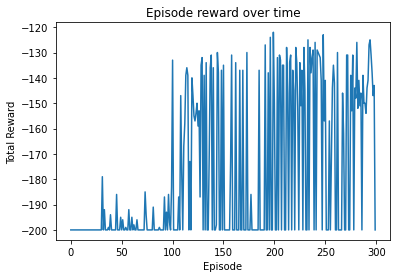

In [94]:
reward_visual(total_reward)

### SARSA FA
On-policy TD with function approximation.

In [95]:
def sarsa(env, estimator, num_episodes, gamma=1.0, epsilon=0.1, eps_decay=0.99):
    # Don't really see a point in adding a decay, but might help -> LambdaLR better
    total_reward_episode = [0] * num_episodes # For graphing
    for episode in tqdm(range(num_episodes)):
        policy = gen_eps_greedy_policy(estimator, epsilon, env.action_space.n)
        state = env.reset()
        action = policy(state)
        is_done = False

        while not is_done:
            next_state, reward, is_done, _ = env.step(action)
            next_q_values = estimator.predict(next_state)
            next_action = policy(next_state)
            td_target = reward + gamma * next_q_values[next_action]
            estimator.update(state, action, td_target)
            total_reward_episode[episode] += reward
            state = next_state
            action = next_action            
        epsilon *= eps_decay
    return total_reward_episode

100%|██████████| 300/300 [00:44<00:00,  6.80it/s]


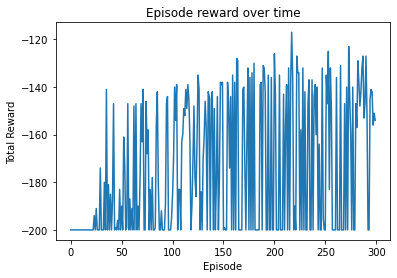

In [96]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_features = 200
lr = 0.03
estimator = QEstimator(num_features, num_states, num_actions, lr)

num_episodes = 300
total_reward = sarsa(env, estimator, num_episodes)

reward_visual(total_reward)

### Experience Replay

Improving learning efficiency by storing agent experiences during the episode instead of performing Q-learning and updating after the end of the episode. Monte Carlo like. But here, we randomly select a few experiences to learn from. This reduces the correlation between data points making learning better.

In [97]:
from collections import deque
import random

In [98]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_features = 200
lr = 0.03
estimator = QEstimator(num_features, num_states, num_actions, lr)

In [99]:
# Buffer for storing experience
memo = deque(maxlen=400)

def exp_q_learning(env, estimator, num_episodes, replay_size, gamma=1.0, epsilon=0.1, eps_decay=0.99):
    total_reward_episode = [0] * num_episodes # For graphing

    for episode in tqdm(range(num_episodes)):
        policy = gen_eps_greedy_policy(estimator, epsilon, env.action_space.n)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            next_q_values = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(next_q_values)
            # Storing experience
            memo.append((state, action, td_target))
            state = next_state
            total_reward_episode[episode] += reward

        replay_data = random.sample(memo, min(replay_size, len(memo)))
        for state, action, td_target in replay_data:
            estimator.update(state, action, td_target)
        epsilon *= eps_decay
    return total_reward_episode

100%|██████████| 1000/1000 [02:39<00:00,  6.25it/s]


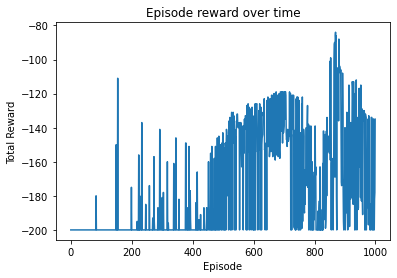

In [100]:
num_episodes = 1000    # More episodes because learning per episode is reduced
replay_size = 200

total_reward = exp_q_learning(env, estimator, num_episodes, replay_size)

reward_visual(total_reward)        # Results are more stable and better

## Neural Network Function Approximation
Using a Artificial Neural Network (`nn.Linear` and `nn.ReLU` layers) with SGD to perform linear regression to perform function approximation. Better Q-learning results.

In [124]:
class NNEstimator():
    def __init__(self, n_f, n_s, n_a, n_h, lr=0.05) -> None:
        # Different parameters of models used for different actions
        self.w, self.b = self.get_gaussian_wb(n_f, n_s)
        self.num_features = n_f
        self.models = []
        self.optims = []
        self.criterion = nn.MSELoss()
        for i in range(n_a):
            # Change basic linear model to a 3 layer Linear Network
            model = nn.Sequential(nn.Linear(self.num_features, n_h), nn.ReLU(), nn.Linear(n_h, 1))
            optim = Adam(model.parameters(), lr)
            self.optims.append(optim)
            self.models.append(model)

    def get_gaussian_wb(self, num_features, num_states, sigma=0.2):
        # Gaussian distribution of weights and biases
        torch.manual_seed(0)
        w = torch.randn((num_states, num_features)) * 1.0 / sigma
        b = torch.randn(num_features) * 2.0 * pi
        return w, b
    
    def get_feature(self, s):
        # Cosine Transform
        features = ((2.0 / self.num_features) ** 0.5) * torch.cos(
                    torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features
    
    def update(self, state, action, target):
        features = Variable(self.get_feature(state))
        y_pred = self.models[action](features)
        loss = self.criterion(y_pred, Variable(torch.Tensor([target])))
        self.optims[action].zero_grad()
        loss.backward()
        self.optims[action].step()
    
    def predict(self, state):
        # Compute Q-value from state using FA
        features = self.get_feature(state)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

In [125]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_features = 200
num_hidden = 50   # Hidden Layer Size
lr = 0.001        # Slower learning rate

estimator = NNEstimator(num_features, num_states, num_actions, num_hidden, lr)

100%|██████████| 1000/1000 [06:42<00:00,  2.48it/s]


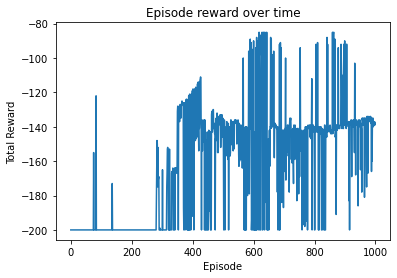

In [126]:
memory = deque(maxlen=300)
num_episodes = 1000
replay_size = 200

total_reward = exp_q_learning(env, estimator, num_episodes, replay_size)

reward_visual(total_reward)

## CartPole-v0 FA
Solving the CartPole environment using function approximation.

In [112]:
env = gym.make("CartPole-v0")

In [119]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_features = 400
num_hidden = 100
lr = 0.01
estimator = NNEstimator(num_features, num_states, num_actions, num_hidden, lr)
# estimator = QEstimator(num_features, num_states, num_actions, lr)

100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


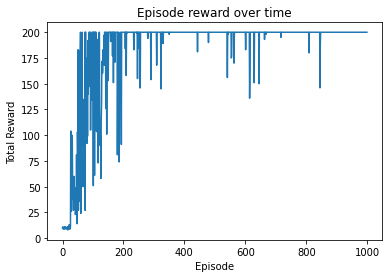

In [120]:
num_episodes = 1000
total_reward = q_learning(env, estimator, num_episodes)

reward_visual(total_reward)